<a href="https://colab.research.google.com/github/AkshitAggarwal/TSAI_EVA5B2_Phase1/blob/main/Session_06/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Call all necessary libraries. 

 Only call libraries and dependencies which are used in the notebook, because each library takes up additional memory. 
  

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy 

### 2. Create data transform compose. 

Use the compose function from `torch.transforms` to compile all necessarry data transformations that you want to apply to your datasets in one place. 

In [ ]:
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ])

### 3. Create datasets. 

Create your `train`, `validate`, `test` datasets and apply the transforms that were created above using compose. 

In [ ]:
train_dataset = datasets.MNIST(root='./data', train = True, transform = train_transforms, download = True)
test_dataset = datasets.MNIST(root='./data', train = False, transform = test_transforms, download = True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 4. Create dataloaders. 

Create dataloaders for respective datasets. Dataloaders are iterable objects that can be fed to the model in smaller, randomized batches to avoid overfitting. 

In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu") #Assigns device based on availability

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#Arguments to be fed into dataloaders. 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

##Train and Test dataloaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

### 5. Data statistics.

Check all necessary data statistics, such as min, max, std, mean values of the dataset. 

### 6. Visualize dataset. 

Take a look at a few images of the training dataset. It gives you an idea of what you're dealing with. By looking at the dataset examples you can determine how difficult your task can be and what kind of transformations may help your model predict better. 

### 7. Define model architecture. 

Create your model class and define model architecture. Keep in mind things like 


1. Model complexity
2. Number of layers
3. Parameters
4. Padding in Conv Layers
5. Kernel size
6. Receptive field



# Ghost Normalization


In [ ]:
class GBN(nn.Module):
  def __init__(self, num_features, groups, eps=1e-05):
    super(GBN, self).__init__()
    self.num_features = num_features
    self.eps = eps
    self.groups = groups

  def forward(self, X):
    """
    X: Input Tensor with (M, C, F) dimensions
    groupsM: Number of groups for the mini-batch dimension
    eps: A small value to prevent division by zero
    """
    # Split the mini-batch dimension into groups of smaller batches
    M, C, x, y = X.shape
    X = X.reshape(self.groups, -1, C, x, y)
    # Calculate statistics over dim(0) x dim(2) number
    # of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=False, keepdim=True)
    # Normalize X
    X = (X - mean) / (torch.sqrt(var + self.eps))
    # Reshape into the initial tensor shape
    X = X.reshape(M, C, x, y)


# New Conv Block

1. Convolution Layer
2. RelU
3. BatchNorm2d

In [ ]:
def convBlock(in_channels, out_channels,*args, **kwargs):
    batch_normalize = nn.ModuleDict([
                                     ['BN', nn.BatchNorm2d(out_channels)],
                                     ['GBN', GBN(out_channels, 10)],
                                     ['None', None]])
    return nn.Sequential([
                          nn.Conv2d(in_channels, out_channels, *args, **kwargs),
                          batch_normalize[kwargs['batch_norm']],
                          nn.ReLU()])

SyntaxError: ignored

In [ ]:
class Net(nn.Module):
    #Constructor function initializes an object of Net() and defines all the layers. 
    #Each layer is defined here separately and aren't connected to each other in any way yet. 
    def __init__(self, **kwargs):
        super(Net, self).__init__()
        self.convBlock1 = convBlock(1, 8, kernel_size = 3, bias = False) #in_channel: 1,28,28; out_channel: 8,26,26; RF: 3
        self.convBlock2 = convBlock(8, 8, kernel_size = 3, bias = False) #in_channel: 8,26,26; out_channel: 8,24,24; RF: 5
        self.pool1 = nn.MaxPool2d(2, 2) #in_channel: 8,24,24; out_channel: 8,12,12; RF: 10
        self.convBlock3 = convBlock(8, 16, kernel_size = 3, bias = False) #in_channel: 8,12,12; out_channel: 16,10,10; RF: 12
        self.convBlock4 = convBlock(16, 16, kernel_size = 3, bias = False) #in_channel: 16,10,10; out_channel: 16,8,8; RF: 14
        self.convBlock5 = convBlock(16, 32, kernel_size = 3, bias = False) #in_channel: 16,8,8; out_channel: 32,6,6; RF: 16
        self.gap = nn.AvgPool2d((6, 6)) #in_channel: 32,6,6; out_channel: 32,1,1; RF: ?
        self.convBlock6 = convBlock(32, 20, kernel_size = 1, bias = False)#in_channels: 32,1,1; out_channels: 20,1,1
        self.convBlock7 = nn.Conv2d(20, 10, 1, bias = False) #in_channel: 20,1,1; out_channel: 10,1,1; 

    #Forward function takes an object and it passes through each layer sequentially. 
    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.pool1(x)
        x = self.convBlock3(x)
        x = self.convBlock4(x)
        x = self.convBlock5(x)
        x = self.gap(x)
        x = self.convBlock6(x)
        x = self.convBlock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim = -1)

### 8. Look at model summary. 

Use `torchsummary` to look at model summary, load the model on gpu if available. 

In [ ]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device) #Converts our model into the respective device.
summary(model, input_size=(1, 28, 28)) #Prints the summary of our model based on an input size.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,152
              ReLU-9           [-1, 16, 10, 10]               0
      BatchNorm2d-10           [-1, 16, 10, 10]              32
           Conv2d-11             [-1, 16, 8, 8]           2,304
             ReLU-12             [-1, 16, 8, 8]               0
      BatchNorm2d-13             [-1, 16, 8, 8]              32
           Conv2d-14             [-1, 3

### 9. Define Train and Test functions

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, L1):
    model.train()
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)

        if(L1 = True):
            l1_penalty = nn.L1Loss(size_average = False)
            reg_loss = 0
            for param in model.parameters():
                reg_loss += l1_penalty(param)
            lambda_l1 = 0.001
            loss += lambda_l1 * reg_loss

        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        description = 'Loss={:.4f} Batch_id={} Accuracy={:.2f}'.format(loss.item(), batch_idx, 100*correct/processed)
        train_acc.append(100*correct/processed)
    print(description)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

### 10. Define optimizer and train the model. 

Train the model for n epochs. 

In [ ]:
def optimizer_pick(L2 = False):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.001) if L2 is True else optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

l1_reg = [L1 = True, L1 = False, L1 = True, L1 = False, L1 = True]

optimizers = [optimizer_pick(L2 = False), optimizer_pick(L2 = True), optimizer_pick(L2 = True), optimizer_pick(L2 = False), optimizer_pick(L2 = True)]

models = [
          Net(batch_norm = 'BN').to(device),
          Net(batch_norm = 'BN').to(device),
          Net(batch_norm = 'BN').to(device),
          Net(batch_norm = 'GBN').to(device),
          Net(batch_norm = 'GBN').to(device),
        ]

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)

EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print('Learning rate: ', optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, L1=True)
    loss = test(model, device, test_loader)
    scheduler.step(loss)

### 11. Visualize model performance

Use matplotlib to plot the model summary to directly compare results. 

Text(0.5, 1.0, 'Test Accuracy')

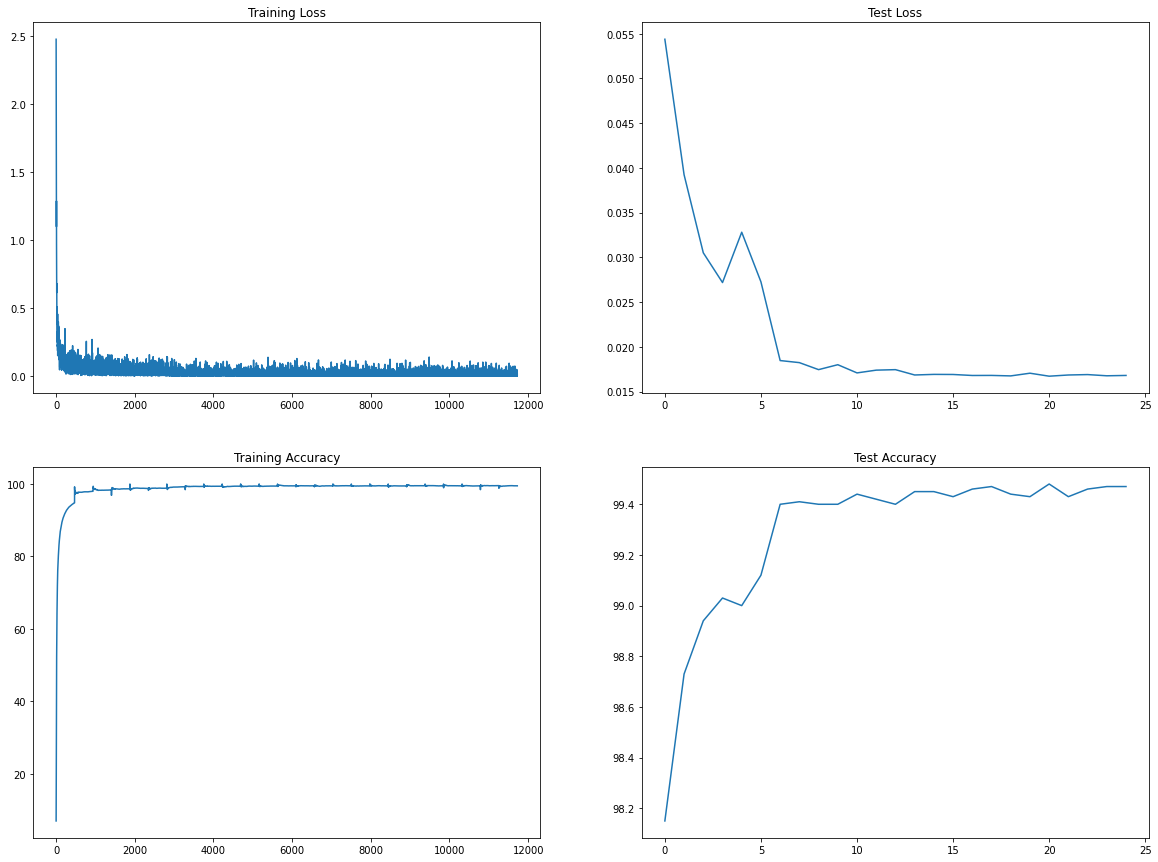

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")